In [1]:
import pandas as pd
from numpy import nan
import numpy as np
import re
import copy

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def openData():
    """
    Opens the csv with the data and cleans the dataset and returns a dataframe.
    """
    # Sort data in descending order by page visibility. This ensures duplicates without page followers are dropped.
#     data = pd.read_csv("../data/facebook_data_cleaned.csv").sort_values('visibility', ascending=False)
#     data = data.drop_duplicates(['altmetric_id'], keep='first')

    data = pd.read_csv("../data/small_data.csv")
    
    data['fb_wall_urls'] = data['fb_wall_urls'].apply(lambda x: eval(x))
    
    def func(inp):
        if inp is nan:
            return inp
        try:
            res = eval(inp)
        except:
            res = [inp]
        return res
    
    data['subjects'] = data['subjects'].map(func)
    data['scopus_subjects'] = data['scopus_subjects'].map(func)
    data['publisher_subjects'] = data['publisher_subjects'].map(func)
    
    data['fb_wall_count'] = data['fb_wall_count'].astype(int)
    
    return data


In [3]:
data = openData()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9334 entries, 0 to 9333
Data columns (total 19 columns):
altmetric_id          9334 non-null float64
title                 9273 non-null object
subjects              4995 non-null object
abstract              6041 non-null object
pubdate               9334 non-null object
fb_wall_count         9334 non-null int32
scopus_subjects       5824 non-null object
publisher_subjects    5659 non-null object
fb_wall_urls          9334 non-null object
shares                9334 non-null int64
visibility            9334 non-null int64
total_like            9334 non-null int64
total_love            9334 non-null int64
total_wow             9334 non-null int64
total_haha            9334 non-null int64
total_sad             9334 non-null int64
total_angry           9334 non-null int64
total_reactions       9334 non-null int64
all_subjects          9334 non-null object
dtypes: float64(1), int32(1), int64(9), object(8)
memory usage: 1.3+ MB


In [230]:
df = copy.deepcopy(data)

## Let's work out the weight of the reactions

We use a similar concept to TF-IDF: the weight of a reaction is inversely proportional to the frequency with which the reaction appears in the entire set


In [231]:
weights = dict()
# weights are similar to inverse-document frequency

for feat in ['total_like', 'total_love', 'total_wow', 'total_haha', 'total_sad', 'total_angry']:
    weights[feat] = np.log(len(df)/(df[feat].apply(lambda x: 1 if x>0 else 0).sum()))

In [232]:
weights

{'total_like': 0.01348238078839396,
 'total_love': 0.27879375710083865,
 'total_wow': 0.7200760607503577,
 'total_haha': 2.033993452399056,
 'total_sad': 1.748155831745923,
 'total_angry': 2.1567026063914954}

In [233]:
# for feat in ['total_like', 'total_love', 'total_wow', 'total_haha', 'total_sad', 'total_angry']:
#     df[feat] = np.log(df[feat] + 1)
#     if feat=='total_like':
#         df[feat] = np.log(df[feat] + 1)
# #         df[feat] = df[feat].apply(lambda x: x**(1/3))
#     df[feat][np.isneginf(df[feat])] = 0
        
for feat in ['total_like', 'total_love', 'total_wow', 'total_haha', 'total_sad', 'total_angry']:
    df[feat] *= weights[feat]

In [234]:
df['total_reacts'] = df['total_like'] + df['total_love'] + df['total_wow'] + df['total_haha'] + df['total_sad'] + df['total_angry']

In [235]:
df['tot_pos'] = (df['total_love'] + ((df['total_wow'] * df['total_love']) /
                                        (df['total_love'] + df['total_sad'] + df['total_angry']))) / df['total_reacts']

df['tot_neg'] = (df['total_angry'] + df['total_sad'] + ((df['total_wow'] * (df['total_angry'] + df['total_sad'])) /
                                        (df['total_love'] + df['total_sad'] + df['total_angry']))) / df['total_reacts']


# df['tot_pos'] = (df['total_love'] + df['total_like'] + (df['total_wow'] * (df['total_love'] + df['total_like']) /
#                                      (df['total_love'] + df['total_sad'] + df['total_angry'] + df['total_like']))) / df['total_reacts']

# df['tot_neg'] = (df['total_angry'] + df['total_sad'] + (df['total_wow'] * (df['total_angry'] + df['total_sad']) /
#                                                         (df['total_love'] + df['total_sad'] + df['total_angry'] + df['total_like']))) / df['total_reacts']

# df['tot_pos'] = df['total_love'] / (df['total_love'] + df['total_sad'] + df['total_angry'])

# df['tot_neg'] = (df['total_angry'] + df['total_sad']) / (df['total_love'] + df['total_sad'] + df['total_angry'])

In [236]:
df['intensity'] = (df['total_love'] + df['total_wow'] + df['total_haha'] + df['total_sad'] + df['total_angry']) / df['total_reacts']
# df['intensity'] = (df['total_love'] + df['total_wow'] + df['total_haha'] + df['total_sad'] + df['total_angry']) / df['total_reacts']

In [237]:
# def f(x):
#     if x > 0:
#         return 1
#     elif x == 0:
#         return 0
#     return -1

df['valence'] = df['tot_pos'] - df['tot_neg']
df['valence'] = df['valence'].apply(lambda x: 1 if x >= 0 else -1)

In [251]:
df['polarity'] = 1 - 4 * abs(np.pi/4 - np.arctan(df['total_angry']/df['total_love'])) / np.pi

df['polarity'] *= df['intensity']

C:\Users\colefreeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arctan
  """Entry point for launching an IPython kernel.


In [239]:
# df['diversity'] = ((df['total_love'].apply(lambda x: 1 if x>0 else 0) + df['total_wow'].apply(lambda x: 1 if x>0 else 0) + 
#                    df['total_haha'].apply(lambda x: 1 if x>0 else 0) + df['total_sad'].apply(lambda x: 1 if x>0 else 0) + 
#                    df['total_angry'].apply(lambda x: 1 if x>0 else 0)) - 1) / 4

df['diversity'] = (df['total_love'].apply(lambda x: 1 if x>0 else 0) + df['total_wow'].apply(lambda x: 1 if x>0 else 0) + 
                   df['total_haha'].apply(lambda x: 1 if x>0 else 0) + df['total_sad'].apply(lambda x: 1 if x>0 else 0) + 
                   df['total_angry'].apply(lambda x: 1 if x>0 else 0)) / 5

df['diversity'] *= df['intensity']

In [240]:
pd.set_option('display.max_columns', None)

pd.set_option('display.max_colwidth', 100)

In [250]:
df.sort_values("polarity", ascending=False).head(500)#.sort_values("total_reactions", ascending=False)

,altmetric_id,title,subjects,abstract,pubdate,fb_wall_count,scopus_subjects,publisher_subjects,fb_wall_urls,shares,visibility,total_like,total_love,total_wow,total_haha,total_sad,total_angry,total_reactions,all_subjects,total_reacts,tot_pos,tot_neg,intensity,valence,polarity,diversity
9194,21731586.0,refugeesnotwelcome antirefugee discourse twitter,NaN,NaN,2017-10-01T00:00:00+00:00,2,[Social Sciences],[Cognitive Science],[{'link': 'https://www.facebook.com/permalink.php?story_fbid=552363325106557&id=240476472961912'...,0,1487,0.000000,0.0,0.000000,0.000000,1.748156,0.0,1,"['Social Sciences', 'Cognitive Science']",1.748156,0.0,1.00000,1.000000,-1,1.000000,0.200000
9192,21412703.0,Annual deterioration of renal function in hypertensive patients with and without diabetes,NaN,Chronic kidney disease (CKD) complicates hypertension and diabetes. Knowledge of the deteriorati...,2017-06-26T00:00:00+00:00,2,"[Medicine, Health Sciences]",[Clinical Sciences],[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1605435969468980&id=305907116088545...,1,1573,0.000000,0.0,0.000000,0.000000,1.748156,0.0,1,"['Medicine', 'Health Sciences', 'Clinical Sciences']",1.748156,0.0,1.00000,1.000000,-1,1.000000,0.200000
8761,16073614.0,David Oliver: Are hospitals heading the same way as prisons?,[medicine],NaN,2017-02-03T00:00:00+00:00,2,"[Medicine, Health Sciences]",[Public Health And Health Services],[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1252409828179689&id=970983602988981...,9,2030,0.000000,0.0,0.720076,0.000000,0.000000,0.0,1,"['medicine', 'Medicine', 'Health Sciences', 'Public Health And Health Services']",0.720076,NaN,NaN,1.000000,-1,1.000000,0.200000
5088,20909916.0,mosquito coinfection zika chikungunya virus allows simultaneous transmission without affecting v...,NaN,zika virus zikv chikungunya virus chikv highly pathogenic arthropodborne viruses currently serio...,2017-06-01T00:00:00+00:00,1,[Health Sciences],[Biological Sciences],"[{'link': 'https://www.facebook.com/permalink.php?story_fbid=10155626279903322&id=335127038321',...",0,0,0.000000,0.0,1.440152,0.000000,0.000000,0.0,2,"['Health Sciences', 'Biological Sciences']",1.440152,NaN,NaN,1.000000,-1,1.000000,0.200000
9299,24916815.0,memoriam martin wolfe,NaN,NaN,2017-09-07T00:00:00+00:00,1,[Health Sciences],[Medical And Health Sciences],[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1457693027611046&id=466266266753732...,0,1337,0.000000,0.0,0.000000,0.000000,1.748156,0.0,1,"['Health Sciences', 'Medical And Health Sciences']",1.748156,0.0,1.00000,1.000000,-1,1.000000,0.200000
8508,17026431.0,Abstract B74: Development of Salmonella-based vaccine against mesothelioma,NaN,NaN,2017-03-01T00:00:00+00:00,1,NaN,NaN,[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1130884743700027&id=356566714465171...,1,-1,0.000000,0.0,0.720076,0.000000,0.000000,0.0,1,[],0.720076,NaN,NaN,1.000000,-1,1.000000,0.200000
5981,28481622.0,Electricity generation from digitally printed cyanobacteria,"[biology, science]",Microbial biophotovoltaic cells exploit the ability of cyanobacteria and microalgae to convert l...,2017-11-06T00:00:00+00:00,1,NaN,[Multidisciplinary],[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1692234154148148&id=680543295317244...,2,-1,0.000000,0.0,0.720076,0.000000,0.000000,0.0,1,"['biology', 'science', 'Multidisciplinary']",0.720076,NaN,NaN,1.000000,-1,1.000000,0.200000
9153,18453201.0,Thoracic spondylolisthesis and spinal cord compression in diffuse idiopathic skeletal hyperostos...,NaN,Diffuse idiopathic skeletal hyperostosis has long been regarded as a benign asymptomatic clinica...,2017-04-01T00:00:00+00:00,2,"[Medicine, Health Sciences]",[General Practice / Family Medicine],[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1683852031631740&id=531016613581960...,5,516,0.000000,0.0,0.000000,0.000000,1.748156,0.0,1,"['Medicine', 'Health Sciences', 'General Practice / Family Medicine']",1.748156,0.0,1.00000,1.000000,-1,

In [244]:
df['diversity'].describe()

count    9334.000000
mean        0.252257
std         0.194560
min         0.000607
25%         0.126557
50%         0.180696
75%         0.326543
max         0.998344
Name: diversity, dtype: float64

In [229]:
df.loc[26]['fb_wall_urls']

[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1707318922626430&id=139382092753462',
  'like': 0,
  'love': 0,
  'wow': 0,
  'haha': 0,
  'sad': 0,
  'angry': 0,
  'page_likes': 3941,
  'page_followers': 3926,
  'message': "It's not clear how proposed extensive powers for the immigration minister strengthen the integrity of Australian citizenship. AAP/Lukas Coch\nThe government has introduced legislation to reform Australia’s citizenship regime, under the guise of strengthening the integrity of citizenship. The bill, if passed in its current form, confers sweeping new powers on the immigration minister. \n\nAccess to Australian citizenship has always involved some executive discretion. But if the bill is passed, the minister will gain unprecedented control over the criteria governing citizenship acquisition, the time it takes for a person to gain citizenship after their application has been approved, and even the circumstances in which citizenship can be revoked. \n\nThe 

In [43]:
df.sample(n=1, replace=True)

,altmetric_id,title,subjects,abstract,pubdate,fb_wall_count,scopus_subjects,publisher_subjects,fb_wall_urls,shares,...,total_sad,total_angry,total_reactions,all_subjects,total_reacts,tot_pos,tot_neg,intensity,valence,polarity
1501,21341035.0,Women in horror: Victims no more,NaN,"According to a recent study, horror is the onl...",2017-06-26T00:00:00+00:00,14,NaN,NaN,[{'link': 'https://www.facebook.com/permalink....,78,...,0.0,0.693147,13,[],5.636649,0.536999,0.149792,0.686791,1,0.346357


In [154]:
np.mean(df['polarity'])# * df['valence'])

0.04742599505521441

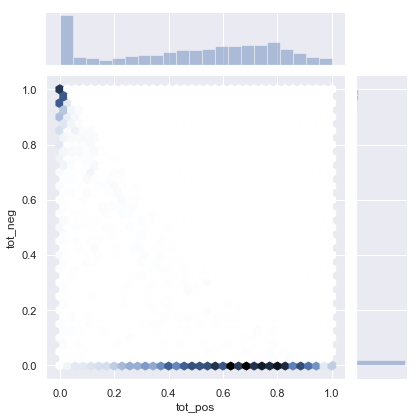

In [224]:
sns.set()

sns.jointplot(x='tot_pos', y='tot_neg', data=df, kind='hex')

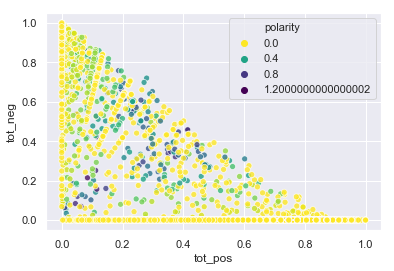

In [252]:
sns.scatterplot(x='tot_pos', y='tot_neg', hue='polarity', data=df, alpha=0.8, palette='viridis_r')

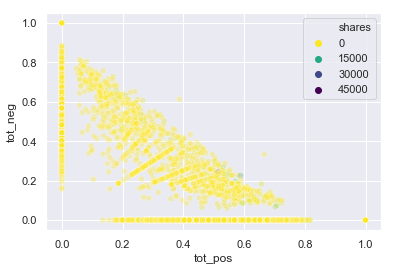

In [140]:
sns.scatterplot(x='tot_pos', y='tot_neg', hue='shares', data=df, alpha=0.3, palette='viridis_r')

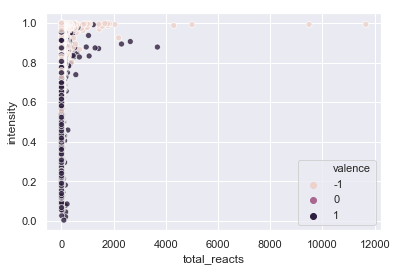

In [222]:
sns.scatterplot(x='total_reacts', y='intensity', hue='valence', data=df, alpha=0.8)

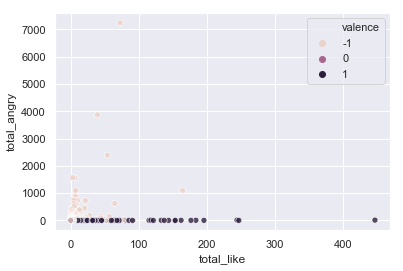

In [223]:
sns.scatterplot(x='total_like', y='total_angry', hue='valence', data=df, alpha=0.8)